# Predicting weather in the next hour using raw data

This notebook demonstrates how we can use vector search for time series forecasting on climate data with Pinecone.
We use the [Jena Climate dataset](https://www.kaggle.com/stytch16/jena-climate-2009-2016) for this example. Jena Climate dataset is made up of quantities such as air temperature, atmospheric pressure, humidity, wind direction, etc. that were recorded every 10 minutes, over several years. 

In a tabular dataset like this, every column can be seen as a feature vector identified uniquely by the time stamp associated with them. We can use these vectors to perform similarity search with a given query vector at a certain time to predict the weather for that hour. Though a very simple embedding extraction process, we want to see how far we can get even with a basic similarity search method like this. We will see how to do with Pinecone in the steps below.



### Install Pinecone




In [ ]:
!pip install -qU pinecone-client

In [9]:
import pinecone

You can get your Pinecone API Key [here](https://www.pinecone.io/start/) if you don't have one.

In [10]:
# Load Pinecone API key
api_key = 'YOUR_API_KEY' 
pinecone.init(api_key=api_key)

### Import other dependencies

In [1]:
import os
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List

mpl.rcParams['figure.figsize'] = (20, 16)
mpl.rcParams['axes.grid'] = False

### Load the dataset

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


Load the hourly data into a dataframe

In [3]:
original_data_for_insert = pd.read_csv(csv_path)
original_data_for_insert = original_data_for_insert[5::6]

original_data_for_insert['Date Time'] = pd.to_datetime(original_data_for_insert['Date Time'], format='%d.%m.%Y %H:%M:%S')

Split data into data that is going to be inserted into Pinecone, and data that is going to be used for querying. 

In [4]:
n = len(original_data_for_insert)
train_data = original_data_for_insert[:int(n*0.9)]
test_data = original_data_for_insert[int(n*0.9):]


Let's see what the data looks like.

In [5]:
train_data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Prepare data for upload. We will be querying data by the date and time.

In [6]:
items_to_upload = []
for row in train_data.values.tolist():
  key = str(row[0])
  values = row[1:]
  items_to_upload.append((key, values))


Prepare data that is going to be queried. 
Here we create two lists - one with dates that are going to be queried and the other one with vectors.



In [7]:
query_dates = []
query_data = []
for row in test_data.values.tolist():
  query_dates.append(str(row[0]))
  query_data.append(row[1:])

### Setting up an index

In [11]:
# Pick a name for the new service
index_name = 'time-series-weather'

In [12]:
# Check whether the index with the same name already exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
pinecone.create_index(name=index_name, metric='cosine', shards=1)

  0%|          | 0/3 [00:00<?, ?it/s]

{'msg': '', 'success': True}

In [14]:
index = pinecone.Index(name = index_name, response_timeout=300)
index.info()

InfoResult(index_size=0)

In [15]:
# Upload items
acks = index.upsert(items=items_to_upload)

0it [00:00, ?it/s]

In [16]:
# Check the index size to confirm the data was upserted properly
index.info()

InfoResult(index_size=63057)

In [17]:
query_results = index.query(queries=query_data, top_k=1)

0it [00:00, ?it/s]

Here we create a function for getting predictions from Pinecone. We do this by using vectors to find the most similar vector in the index and then reading the hour after that.

In [18]:
def get_predictions(feature: str) -> (List, List):

    true_values = []
    predicted_values = []

    for test_date, qr in zip(query_dates, query_results):
        similar_date = qr.ids[0]

        hour_from_original = datetime.strptime(str(test_date), '%Y-%m-%d %H:%M:%S') + timedelta(hours=1) 
        hour_from_similar = datetime.strptime(similar_date, '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)

        original_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_original][feature].tolist()
        similar_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_similar][feature].tolist()

        if original_temperature and similar_temperature:
            true_values.append(original_temperature[0])
            predicted_values.append(similar_temperature[0])
    return true_values, predicted_values


In [19]:
def plot_results(predicted_values: List, true_values: List):
    x_list = range(0, len(predicted_values))
    plt.plot(x_list[:200], predicted_values[:200], label='forecast')
    plt.plot(x_list[:200], true_values[:200], label='true')
    plt.legend()
    plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_results(true_values: List, predicted_values: List):
    print(f'MSE: {mean_squared_error(true_values, predicted_values)}')
    print(f'RMSE: {mean_squared_error(true_values, predicted_values, squared=False)}')
    print(f'MAE: {mean_absolute_error(true_values, predicted_values)}')

### Results

To evaluate our results we will plot the predicted and true values for all the 14 features. 

Analyzing predictions for p (mbar)


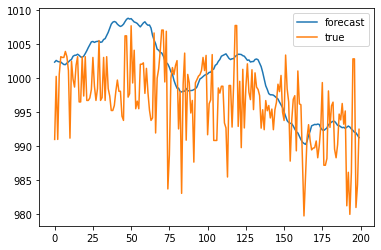

MSE: 28.98955931792237
RMSE: 5.384195326873122
MAE: 4.150626426940639
Analyzing predictions for T (degC)


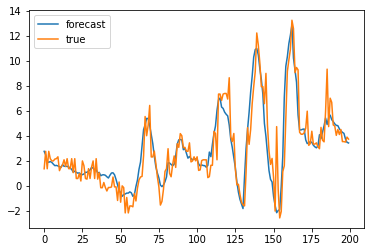

MSE: 2.160220876141553
RMSE: 1.4697689873383344
MAE: 1.0966452625570777
Analyzing predictions for Tpot (K)


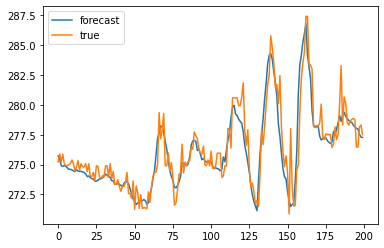

MSE: 2.1634587043378994
RMSE: 1.4708700501192822
MAE: 1.0963898401826484
Analyzing predictions for Tdew (degC)


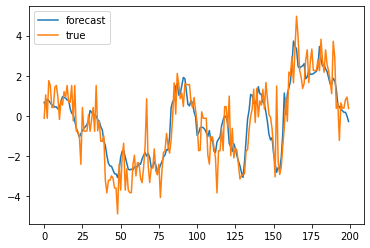

MSE: 1.0185260273972603
RMSE: 1.0092205048438425
MAE: 0.7654880136986302
Analyzing predictions for rh (%)


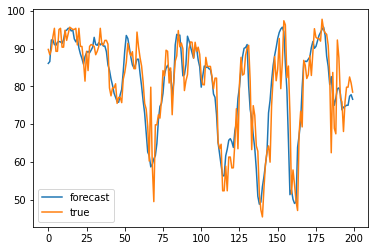

MSE: 41.976068621575344
RMSE: 6.478894089393293
MAE: 4.701302796803653
Analyzing predictions for VPmax (mbar)


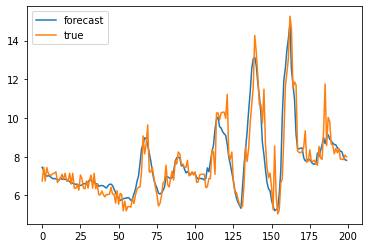

MSE: 3.0582269263698634
RMSE: 1.7487786956530158
MAE: 1.160406678082192
Analyzing predictions for VPact (mbar)


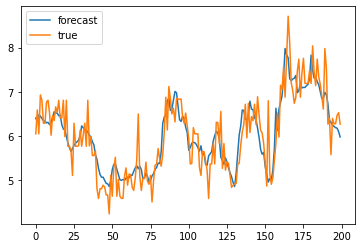

MSE: 0.5957593179223744
RMSE: 0.7718544668021131
MAE: 0.5512656963470319
Analyzing predictions for VPdef (mbar)


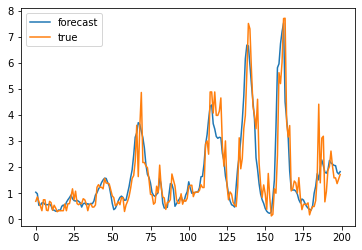

MSE: 3.0894142265981737
RMSE: 1.7576729578047714
MAE: 1.09517551369863
Analyzing predictions for sh (g/kg)


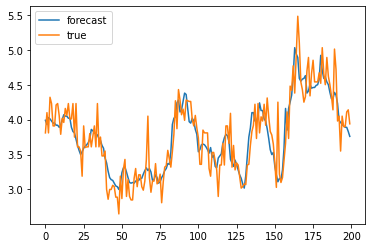

MSE: 0.23456807933789955
RMSE: 0.48432228870649713
MAE: 0.34388270547945204
Analyzing predictions for H2OC (mmol/mol)


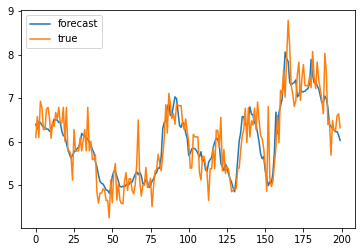

MSE: 0.5940185216894978
RMSE: 0.7707259705560062
MAE: 0.5478909817351598
Analyzing predictions for rho (g/m**3)


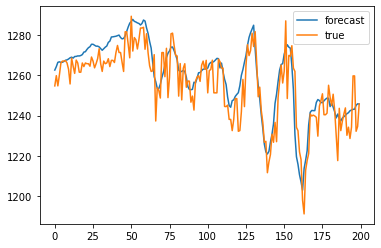

MSE: 69.6147680650685
RMSE: 8.343546492054113
MAE: 6.474751712328767
Analyzing predictions for wv (m/s)


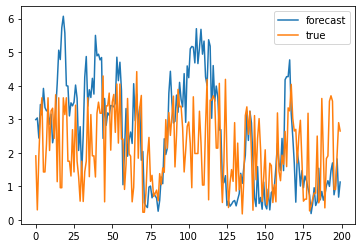

MSE: 1.729314026826484
RMSE: 1.315033850068691
MAE: 0.976488299086758
Analyzing predictions for max. wv (m/s)


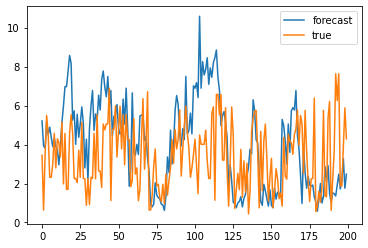

MSE: 4.138833319063926
RMSE: 2.034412278537447
MAE: 1.511970605022831
Analyzing predictions for wd (deg)


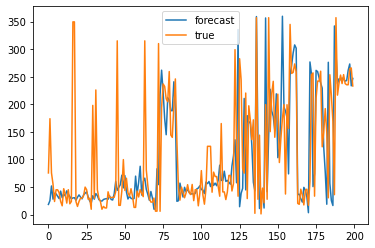

MSE: 9438.43649158105
RMSE: 97.15161600087283
MAE: 62.900182648401824


In [21]:
for feature in original_data_for_insert.columns[1:]:
    print(f'Analyzing predictions for {feature}')
    true_values, predicted_values = get_predictions(feature)
    plot_results(true_values, predicted_values)
    print_results(true_values, predicted_values)

### Summary

From the plots above we can see that the method is able to predict pretty accurately for feature like VPdef, VPmax, rh(%) etc. predict roughly accurately for features like H20C, rho and is not that great for features like wd, max.vv, wv. Given how simple the approach is and doesn't involve any feature engineering, it does pretty good in some spots! 

We can improve these predictions by using more complex methods like LSTMs which are better suited to handle data like these.

### Delete the Index

Once we don't have use of the index we can delete them.


*Note: Index deletion is permanent*

In [ ]:
for name in pinecone.list_indexes():
  pinecone.delete_index(name)